# Text Document Classification with KNN and Naive Bayes

In this tutorial you will classify text documents using Naive Bayes classifers.  We will be working with the dataset called "20 Newsgroups", which is a collection of 20,000 newsgroup posts organized into 20 categories.

## Loading the 20 Newsgroups Dataset
The dataset is called “20 Newsgroups”. Here is the official description, quoted from the [website](http://qwone.com/~jason/20Newsgroups/)
>The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

In [1]:
#First we need to initialize Python.  Run the below cell.
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(4487)

C:\Users\Sean\AppData\Local\Temp/ipykernel_12612/822221248.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


- Put the file "20news-bydate_py3.pkz' into the same directory as this ipynb file. **Do not unzip the file**.

- Extract 4 classes ('alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space') from the dataset. 

In [2]:
# strip away headers/footers/quotes from the text
removeset = ('headers', 'footers', 'quotes')

# only use 4 categories
cats      = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# load the training and testing sets
newsgroups_train = datasets.fetch_20newsgroups(subset='train',
                            remove=removeset, categories=cats, data_home='./')
newsgroups_test  = datasets.fetch_20newsgroups(subset='test', 
                           remove=removeset, categories=cats, data_home='./')

- Check if we got all the data.  The training set should have 2034 documents, and the test set should have 1353 documents.

In [3]:
print("training set size:", len(newsgroups_train.data))
print("testing set size: ",  len(newsgroups_test.data))
print(newsgroups_train.target_names)

training set size: 2034
testing set size:  1353
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


- Count the number examples in each class.  `newsgroups_train.target` is an array of class values (0 through 3), and `newsgroups_train.target[i]` is the class of the i-th document.

In [4]:
print("class counts")
for i in [0, 1, 2, 3]:
    print("{:20s}: {}".format(newsgroups_train.target_names[i], sum(newsgroups_train.target == i)))

class counts
alt.atheism         : 480
comp.graphics       : 584
sci.space           : 593
talk.religion.misc  : 377


- Show the documents.  `newsgroups_train.data` is a list of strings, and `newsgroups_train.data[i]` is the i-th document.

In [5]:
for i in [0, 1, 2 ,3]:
    print("--- document {} (class={}) ---".format(
        i, newsgroups_train.target_names[newsgroups_train.target[i]]))
    print(newsgroups_train.data[i])

--- document 0 (class=comp.graphics) ---
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
--- document 1 (class=talk.religion.misc) ---


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil 

**Tip:** while you do the tutorial, it is okay to make additional code cells in the file.  This will allow you to avoid re-running code (like training a classifier, then testing a classifier).

## Extracting Features from Text Files
In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

Next, we will introduce two basic text representation methods: One-hot encoding, Bag of words, and TF-IDF. More feature vector extraction functions, please refer to https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction

### One-hot Encoding
- Each word is coded with an index, which is represented by one-hot.

> John likes to watch movies. Mary likes too.

> John also likes to watch football games.

If we need to represent the words in the above two sentences, you can encode the words as following:

> {"John": 1, "likes": 2, "to": 3, "watch": 4, "movies": 5, "also":6, "football": 7, "games": 8, "Mary": 9, "too": 10}

We can encode each word using one-hot method

>John: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

>likes: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

>...

However, this text representation method gives outputs of differnent lengths for different documents, which by far we are not able to handle.

### Bag of Words
- The index value of a word in the vocabulary is linked to its count in the whole training corpus.

> John likes to watch movies. Mary likes too.  -->> [1, 2, 1, 1, 1, 0, 0, 0, 1, 1]

> John also likes to watch football games.     -->> [1, 1, 1, 1, 0, 1, 1, 1, 0, 0]

The **sklearn.feature_extraction.text.CountVectorizer** implement the `Bag of Words` method that converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using **scipy.sparse.coo_matrix** to save memory by only storing the non-zero parts of the feature vectors in memory.

### Term Frequency - Inverse Document Frequency (TF-IDF)

In the word bag model, we can get the vector representation of this text. However, in the face of the diversity of text, each word has different weight to the content of text in practical application, so we introduce tf-idf model.

##### TF (Term Frequency)

In the case of the term frequency $\text{tf}(t, d)$, the simplest choice is to use the raw count of a term in a document, i.e., the number of times that term $t$ occurs in document $d$. If we denote the raw count by $f_{t, d}$, then the simplest tf scheme is $\text{tf}(t,d) = f_{t, d}$. 

$$
\text{tf}_{t, d} = \frac{f_{t, d}}{\sum_{t'}f_{t', d}}
$$

The numerator in the above formula is the number of occurrences of the word in the document $d$, and the denominator is the sum of the occurrences of all words $t^{'}$ in the document $d$.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
 
corpus = ['This is the first document.',
	'This document is the second document.',
	'And this is the third one.',
	'Is this the first document?']
 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
 
print(vectorizer.get_feature_names())
print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### IDF (Inverse Document Frequency) 

The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient): 

$\text{idf}(t ,\mathcal{D}) = log\frac{N}{|\{ d\in \mathcal{D}:t \in d \}|}$

with 
- $N$: total number of documents in the corpus $N=|\mathcal{D}|$
- $|\{ d\in \mathcal{D}:t \in d \}|$: number of documents where the term $t$ appears. If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to  $1+|\{ d\in \mathcal{D}:t \in d \}|$

Then tf-idf is calculated as: 
$\text{tfidf}(t, d, \mathcal{D}) = \text{tf}(t, d) * \text{idf}(t, \mathcal{D})$

Both tf and tf–idf can be computed as follows using **sklearn.feature_extraction.text.TfidfTransformer**.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
texts=["dog cat fish","dog cat cat","dog fish", 'dog pig pig bird']
cv = CountVectorizer()
cv_fit=cv.fit_transform(texts)

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(cv_fit)

print (tfidf.toarray())

[[0.         0.64043405 0.42389674 0.64043405 0.        ]
 [0.         0.94936136 0.31418628 0.         0.        ]
 [0.         0.         0.55193942 0.83388421 0.        ]
 [0.43551105 0.         0.22726773 0.         0.8710221 ]]


Create the vocabulary from the training data.  Then use **sklearn.feature_extraction.text.CountVectorizer** to build the document vectors for the training and testing sets.  You can decide how many words you want in the vocabulary

In [8]:
cntvect = feature_extraction.text.CountVectorizer(stop_words='english')
transformed_train = cntvect.fit_transform(newsgroups_train.data)
print(cntvect.get_feature_names()[:20])

['00', '000', '0000', '00000', '000000', '000005102000', '000062david42', '0001', '000100255pixel', '00041032', '0004136', '0004246', '0004422', '00044513', '0004847546', '0005', '0007', '00090711', '000usd', '0012']


## K Nearest Neighbor (KNN)
Let's train a K Nearest Neighbor (KNN) model. Using cross-validation to select the best K parameter. Then, showing the accuracy of training and testing set.

In [9]:
## HINT
# 1. C: paramgrid = {'n_neighbors': [3,5,7]}
# 2. cross-validation: clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=paramgrid, cv=10, n_jobs=-1)
# 3. To find the best K: print(clf.best_params_)

paramgrid = {'n_neighbors': [3,5,7]}
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=paramgrid, cv=10, n_jobs=-1)
clf.fit(transformed_train, newsgroups_train.target)

transformed_test = cntvect.transform(newsgroups_test.data)
test_res = clf.predict(transformed_test)
acc = metrics.accuracy_score(newsgroups_test.target, test_res)
print("The validation accuracies for different parameter are: ", clf.cv_results_['mean_test_score'])
print("The best K will be: ", clf.best_params_)
print("The test accuracy is: ", acc)

The validation accuracies for different parameter are:  [0.41055491 0.38347339 0.37016807]
The best K will be:  {'n_neighbors': 3}
The test accuracy is:  0.4050258684405026


## Bernoulli Naive Bayes 
Learn a Bernoulli Naive Bayes model from the training set.  What is the prediction accuracy on the test set?  Try different parameters (alpha, max_features, etc) to get the best performance.

In [10]:
## HINT
# 1. bmodel = naive_bayes.BernoulliNB(alpha=0.1); 
# 2. The model automatically converts count vector into binary vector 

alphas = logspace(-5, 0, 10)
max_features = linspace(10, len(cntvect.get_feature_names()), 10).astype(int)

for max_feature in max_features:
    vectorizer = feature_extraction.text.CountVectorizer(stop_words='english',max_features=max_feature)
    transformedtrain = vectorizer.fit_transform(newsgroups_train.data)
    transformedtest = vectorizer.transform(newsgroups_test.data)
    paramgrid = {'alpha': alphas}
    param_search = model_selection.GridSearchCV(naive_bayes.BernoulliNB(), paramgrid, cv=10, n_jobs=-1)
    param_search.fit(transformedtrain, newsgroups_train.target)
    bmodel_test_res = param_search.predict(transformedtest)
    bmodel_acc = metrics.accuracy_score(newsgroups_test.target, bmodel_test_res)
    print("When max_feature is: {}, best accuracy is: {} with {}"
        .format(max_feature, bmodel_acc, param_search.best_params_))

# Choose max_feature to be 23624, alpha to be 1e-5    
vectorizer = feature_extraction.text.CountVectorizer(stop_words='english',max_features=18000)
transformedtrain = vectorizer.fit_transform(newsgroups_train.data)
transformedtest = vectorizer.transform(newsgroups_test.data)
bmodel = naive_bayes.BernoulliNB(alpha=1e-5)
bmodel.fit(transformedtrain, newsgroups_train.target)
# print(metrics.accuracy_score(bmodel.predict(transformedtest), newsgroups_test.target))

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


When max_feature is: 10, best accuracy is: 0.42941611234294164 with {'alpha': 1e-05}
When max_feature is: 2961, best accuracy is: 0.6881005173688101 with {'alpha': 0.0004641588833612782}
When max_feature is: 5913, best accuracy is: 0.7087952697708795 with {'alpha': 3.5938136638046256e-05}
When max_feature is: 8865, best accuracy is: 0.721359940872136 with {'alpha': 1e-05}
When max_feature is: 11817, best accuracy is: 0.729490022172949 with {'alpha': 1e-05}
When max_feature is: 14768, best accuracy is: 0.7287509238728751 with {'alpha': 1e-05}
When max_feature is: 17720, best accuracy is: 0.7302291204730229 with {'alpha': 1e-05}
When max_feature is: 20672, best accuracy is: 0.7346637102734663 with {'alpha': 1e-05}
When max_feature is: 23624, best accuracy is: 0.7405764966740577 with {'alpha': 1e-05}
When max_feature is: 26576, best accuracy is: 0.7324464153732446 with {'alpha': 1e-05}


BernoulliNB(alpha=1e-05)

What are the most informative words for each category?  Run the below code.

Note: `model.coef_[i]` will index the scores for the i-th class

In [11]:
# get the word names
fnames = asarray(cntvect.get_feature_names())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(bmodel.feature_log_prob_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], bmodel.feature_log_prob_[i][t]))

class alt.atheism
    min       (-1.80434)
    colloquium (-1.60944)
    encountered (-1.60944)
    defended  (-1.58882)
    escapism  (-1.54881)
    jc        (-1.52940)
    eloquent  (-1.45529)
    meteorologie (-1.39466)
    gotcha    (-1.29859)
    colorstudio (-1.19018)
class comp.graphics
    eloquent  (-1.95106)
    colorstudio (-1.91555)
    heiko     (-1.88126)
    footprint (-1.85904)
    colloquium (-1.74493)
    newcastle (-1.73517)
    escapism  (-1.60773)
    encountered (-1.51009)
    deliver   (-1.49470)
    mercedes  (-1.47206)
class sci.space
    compass_mag_fp (-1.90786)
    newcastle (-1.88538)
    min       (-1.77007)
    encountered (-1.73123)
    foc       (-1.73123)
    meteorologie (-1.73123)
    colorstudio (-1.69385)
    eloquent  (-1.47254)
    escapism  (-1.41538)
    literatures (-1.01922)
class talk.religion.misc
    jc        (-1.65558)
    old       (-1.62818)
    escapism  (-1.61476)
    colloquium (-1.53780)
    encountered (-1.48959)
    meteorologie

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Multinomial Naive Bayes model
Now learn a multinomial Naive Bayes model using the TF-IDF representation for the documents.  Again try different parameter values to improve the test accuracy.

In [12]:
## HINT
# 1. feature_extraction.text.TfidfTransformer(use_idf=True, norm= )
# 2. naive_bayes.MultinomialNB(alpha= )

norms = ['l1', 'l2']
paramgrid = {'alpha':logspace(-5, 0, 10)}

for norm in norms:
    tfidf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm=norm)
    tfidf_train = tfidf_trans.fit(transformed_train).transform(transformed_train)
    tfidf_test = tfidf_trans.transform(transformed_test)
    print(type(tfidf_test[0]))
    print(tfidf_test[0])
    param_search = model_selection.GridSearchCV(naive_bayes.MultinomialNB(), paramgrid, cv=10, n_jobs=-1)
    param_search.fit(tfidf_train, newsgroups_train.target)
    mmodel_test_res = param_search.predict(tfidf_test)
    mmodel_acc = metrics.accuracy_score(newsgroups_test.target, mmodel_test_res)
    print("When normalization method is: {}, best accuracy is: {} with {}"
        .format(norm, mmodel_acc, param_search.best_params_))

# Choose normalization method to be l2, alpha to be 0.07
tfidf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
tfidf_train = tfidf_trans.fit_transform(transformed_train)
tfidf_test = tfidf_trans.transform(transformed_test)

mmodel_tf = naive_bayes.MultinomialNB(alpha=0.07)
mmodel_tf.fit(tfidf_train, newsgroups_train.target)
tfidf_test_res = mmodel_tf.predict(tfidf_test)
print(metrics.accuracy_score(newsgroups_test.target, tfidf_test_res))

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 19167)	0.4238552734012535
  (0, 3612)	0.5761447265987465
When normalization method is: l1, best accuracy is: 0.7730968218773097 with {'alpha': 3.5938136638046256e-05}
<class 'scipy.sparse._csr.csr_matrix'>
  (0, 19167)	0.5925895712595968
  (0, 3612)	0.8055045623920247
When normalization method is: l2, best accuracy is: 0.7923133776792314 with {'alpha': 0.07742636826811278}
0.7915742793791575


What are the most informative features for Multinomial model? Run the below code.

In [13]:
# get the word names
fnames = asarray(cntvect.get_feature_names())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(mmodel_tf.feature_log_prob_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], mmodel_tf.feature_log_prob_[i][t]))

class alt.atheism
    islam     (-6.53000)
    does      (-6.42456)
    religion  (-6.34876)
    atheism   (-6.33115)
    say       (-6.27515)
    just      (-6.20797)
    think     (-6.08855)
    don       (-5.98745)
    people    (-5.95371)
    god       (-5.73348)
class comp.graphics
    windows   (-6.31492)
    does      (-6.30355)
    looking   (-6.29169)
    program   (-6.20581)
    know      (-6.16292)
    file      (-6.06937)
    image     (-6.03466)
    files     (-6.02754)
    thanks    (-5.79962)
    graphics  (-5.58950)
class sci.space
    earth     (-6.64225)
    think     (-6.62679)
    shuttle   (-6.62291)
    orbit     (-6.46403)
    moon      (-6.45623)
    just      (-6.44784)
    launch    (-6.44577)
    like      (-6.32109)
    nasa      (-6.11302)
    space     (-5.34287)
class talk.religion.misc
    objective (-6.59533)
    think     (-6.54948)
    just      (-6.53550)
    bible     (-6.52196)
    don       (-6.50625)
    christians (-6.49427)
    christian (-6.28

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


How do the most informative words differ between the TF-IDF multinomial model and the Bernoulli model?

- There are more domain-specific words appeared in top-ranked informative words for each class. The reason may be the weight added to each word by the $idf$ term. Since if a word appears in most documents, it provides little information on differentiating classes. But if a word appears frequently only in certain class of documents, given sample size of all classes are quite even, the word would tell much about the class of its belonging document, i.e. $idf$ term would be large.

- the TF-IDF words are more specific, e.g., for religion.misc, {christians, jesus, god} from TF-IDF feature, compared {people, just, don} from appearance feature.

## Effect of Smoothing
The smoothing (regularization) parameter has a big effect on the performance.  Using the Multinomial TF-IDF models, make a plot of accuracy versus different values of alpha. For each alpha, you need to train a new model. Which alpha value yields the best result?

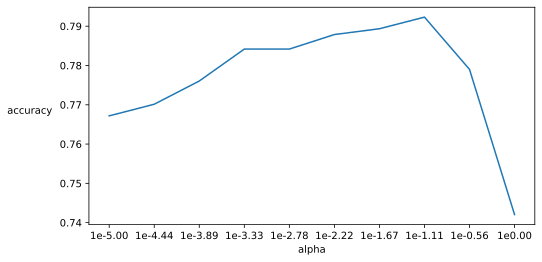

The best accuracy is obtained with alpha being:  0.07742636826811278


In [14]:
## HINT
# 1. Iterating: alphas = logspace(-5,0,50)

tfidf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
tfidf_train = tfidf_trans.fit_transform(transformed_train)
tfidf_test = tfidf_trans.transform(transformed_test)

alphas = logspace(-5, 0, 10)
accs = []
for alpha in alphas:
    mmodel_alpha = naive_bayes.MultinomialNB(alpha=alpha)
    mmodel_alpha.fit(tfidf_train, newsgroups_train.target)
    alpha_test_res = mmodel_alpha.predict(tfidf_test)
    alpha_acc = metrics.accuracy_score(newsgroups_test.target, alpha_test_res)
    accs.append(alpha_acc)

xticks = [x for x in range(10)]
plt.figure(figsize=(8,4))
plt.plot(xticks, accs)
plt.xlabel('alpha')
plt.ylabel('accuracy', rotation=0, labelpad=30)
plt.xticks(xticks, ['1e{:.2f}'.format(x) for x in linspace(-5, 0, 10)])
plt.show()

print("The best accuracy is obtained with alpha being: ", alphas[argmax(accs)])

## Effect of Vocabulary Size
The vocabulary size also affects the accuracy.  Make another plot of accuracy versus vocabulary size.  Which vocabulary size yields the best result?

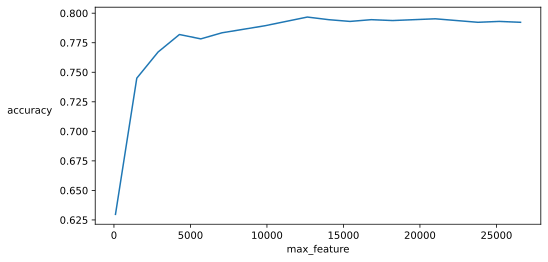

The best accuracy is obtained with max_feature being:  12641


In [15]:
## HINT
# 1. Iterating: maxfeatures = linspace(100,26577,20)

maxfeatures = linspace(100,26577,20).astype(int)
accs = []
for maxfeature in maxfeatures:
    vect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=maxfeature)
    train = vect.fit_transform(newsgroups_train.data)
    test = vect.transform(newsgroups_test.data)

    tfidf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
    tfidf_train = tfidf_trans.fit(train).transform(train)
    tfidf_test = tfidf_trans.transform(test)
                                       
    model = naive_bayes.MultinomialNB(alpha=0.077)
    model.fit(tfidf_train, newsgroups_train.target)
    test_res = model.predict(tfidf_test)
    acc = metrics.accuracy_score(newsgroups_test.target, test_res)
    accs.append(acc)

plt.figure(figsize=(8,4))
plt.plot(maxfeatures, accs)
plt.xlabel('max_feature')
plt.ylabel('accuracy', rotation=0, labelpad=30)
plt.show()

print("The best accuracy is obtained with max_feature being: ", maxfeatures[argmax(accs)])